In [ ]:
# E-Commerce Customer Behavior Analysis Project

In [18]:
# =========================
# 0. Imports and Setup
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
#fr

# Optional: ignore warnings for clean output
import warnings
warnings.filterwarnings('ignore')

# Set global plotting style
sns.set_style('whitegrid')


In [19]:
#1. Load Data from BigQuery
from google.cloud import bigquery
from google.colab import auth

# Authenticate with Google Colab
auth.authenticate_user()

# Set your project ID
project_id = 'ecommerce-474706'
client = bigquery.Client(project=project_id)

# Table names
tables_to_load = {
    "customers": "Customer_Profile_Demographics",
    "orders": "Order_Transaction_Master",
    "products": "Product_Catalog_Master",
    "product_review": "Product_Reviews_Ratings",
    "web_session": "Web_Session_Traffic",
    "user_clicks": "User_Interactions_Clicks",
    "cart_activity": "Shopping_Cart_Activity",
    "service_tickets": "Customer_Service_Tickets",
    "marketing": "Marketing_Campaign_Exposure",
    "returns": "Returns_Refunds_Logistics"
}

# Load data (limit 1000 for demo)
data = {}
for key, table in tables_to_load.items():
    query = f"""
    SELECT *
    FROM `ecommerce-474706.ecommerce.{table}`LIMIT 10 """
    data[key] = client.query(query).to_dataframe()

# Assign variables
customers = data['customers']
orders = data['orders']
products = data['products']
product_review = data['product_review']
web_session = data['web_session']
user_clicks = data['user_clicks']
cart_activity = data['cart_activity']
service_tickets = data['service_tickets']
marketing = data['marketing']
returns = data['returns']

# Preview customer data
customers.head()

,Customer_ID,Registration_Date,Email_Domain,Gender,Age,Income_Range,Region,Timezone_Offset,Marital_Status,Has_Children,...,Lifetime_Orders__Last_30D_81,Avg_Review_Rating__Desktop_82,Unique_Products_Purchased__Q1_83,Lifetime_Orders__Q1_84,Lifetime_Orders__Last_30D_85,Days_Since_First_Purchase__Last_30D_86,Avg_Order_Value__Q1_87,Avg_Review_Rating__Total_88,Unique_Products_Purchased__Mobile_89,Days_Since_First_Purchase__Mobile_90
0,CUST000048,2025-09-08,outlook.com,Female,66,< $30K,West,3.0,Married,True,...,1,3.61,19,1,0,664,0.00,3.17,24,951
1,CUST000378,2025-06-01,gmail.com,Male,58,$30K - $60K,South,5.5,Single,False,...,0,3.70,0,1,1,709,24.17,2.73,0,708
2,CUST001288,2022-09-20,gmail.com,Male,23,< $30K,South,5.5,Single,False,...,0,4.09,37,1,1,757,62.74,3.54,44,623
3,CUST001396,2020-10-08,hotmail.com,Female,63,$30K - $60K,South,1.0,Married,True,...,1,3.29,35,0,0,1266,42.18,3.60,28,1202
4,CUST001665,2024-10-15,outlook.com,Prefer Not to Say,46,$100K+,South,3.0,Single,True,...,0,2.56,3,0,0,910,20.09,4.28,3,1113


In [3]:
products.shape

(100000, 115)

In [4]:
customers.shape

(100000, 105)

In [20]:
# 2. Merge Orders, Customers, Products, and Reviews
# Merge product reviews with products
product_review_full = product_review.merge(products, on='Product_ID', how='left')

# Merge orders with customers
orders_customers = orders.merge(customers, on='Customer_ID', how='left')

# Merge orders + customers with product reviews
df_full = orders_customers.merge(product_review_full, on='Customer_ID', how='left')

# Preview
df_full.head()


,Order_ID,Customer_ID,Order_Date,Order_Status,Total_Amount_USD,Total_Items_Count,Payment_Method,Shipping_Type,Shipping_Cost_USD,Coupon_Code_Used,...,Compatibility_Score__Cotton_91,Environmental_Impact_Score__Cotton_92,Material_Recycled_Pct__v2_93,Rating_System_Value__EU_Reg_94,Is_Seasonal_Flag__Metal_95,Certification_Level__Physical_96,Warranty_Months__v2_97,Dimension_Height_cm__Metal_98,Compatibility_Score__Physical_99,Packaging_Type_Code__v2_100
0,ORD00000001,CUST015796,2024-12-09 00:04:32+00:00,Completed,134.30,4,Credit Card,Economy,4.00,NONE,...,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>
1,ORD00000002,CUST000861,2024-09-04 22:54:57+00:00,Shipped,2001.87,2,Digital Wallet,Standard,7.74,FREESHIP,...,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>
2,ORD00000003,CUST076821,2024-11-22 10:26:33+00:00,Completed,233.57,1,PayPal,Standard,5.67,NONE,...,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>
3,ORD00000004,CUST054887,2024-06-15 16:11:54+00:00,Shipped,300.11,5,PayPal,Express,0.75,NONE,...,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>
4,ORD00000005,CUST006266,2024-05-04 21:55:03+00:00,Completed,536.28,3,Credit Card,Express,14.16,NONE,...,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>


In [21]:
df_full.shape

(10, 447)

In [22]:
# Convert Order_Date to datetime
df_full['Order_Date'] = pd.to_datetime(df_full['Order_Date'])
analysis_date = df_full['Order_Date'].max() + timedelta(days=1)

# Compute RFM metrics
rfm = df_full.groupby('Customer_ID').agg({
    'Order_Date': lambda x: (analysis_date - x.max()).days,
    'Order_ID': 'nunique',
    'Total_Amount_USD': 'sum'
}).reset_index()
rfm.rename(columns={'Order_Date':'Recency','Order_ID':'Frequency','Total_Amount_USD':'Monetary'}, inplace=True)

# RFM quartile scores
rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Customer segments
def segment_customer(row):
    if row['RFM_Score'] in ['444','443','434']:
        return 'Champion'
    elif row['RFM_Score'] in ['111','112','121']:
        return 'Lost'
    elif row['RFM_Score'] in ['211','212','221']:
        return 'At-Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# Merge with customer demographics
rfm_full = rfm.merge(customers, on='Customer_ID', how='left')



In [23]:
rfm_full.head()

,Customer_ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Registration_Date,...,Lifetime_Orders__Last_30D_81,Avg_Review_Rating__Desktop_82,Unique_Products_Purchased__Q1_83,Lifetime_Orders__Q1_84,Lifetime_Orders__Last_30D_85,Days_Since_First_Purchase__Last_30D_86,Avg_Order_Value__Q1_87,Avg_Review_Rating__Total_88,Unique_Products_Purchased__Mobile_89,Days_Since_First_Purchase__Mobile_90
0,CUST000861,221,1,2001.87,3,1,4,314,Others,NaT,...,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>
1,CUST006266,344,1,536.28,1,1,4,114,Others,NaT,...,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>
2,CUST015796,126,1,134.30,4,1,1,411,Others,NaT,...,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>
3,CUST037195,512,1,71.08,1,2,1,121,Lost,NaT,...,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>
4,CUST044132,392,1,386.78,1,2,4,124,Others,NaT,...,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>


In [24]:
# 2. Customer Lifetime Value (CLV)

clv_df = df_full.groupby('Customer_ID').agg({
    'Order_ID': 'nunique',
    'Total_Amount_USD': 'sum',
    'Order_Date': [min, max]
}).reset_index()
clv_df.columns = ['Customer_ID','Frequency','Monetary','First_Purchase','Last_Purchase']
clv_df['Customer_Lifetime'] = (clv_df['Last_Purchase'] - clv_df['First_Purchase']).dt.days + 1
clv_df['AOV'] = clv_df['Monetary'] / clv_df['Frequency']
clv_df['CLV_Historical'] = clv_df['AOV'] * clv_df['Frequency']



In [25]:
clv_df.head()

,Customer_ID,Frequency,Monetary,First_Purchase,Last_Purchase,Customer_Lifetime,AOV,CLV_Historical
0,CUST000861,1,2001.87,2024-09-04 22:54:57+00:00,2024-09-04 22:54:57+00:00,1,2001.87,2001.87
1,CUST006266,1,536.28,2024-05-04 21:55:03+00:00,2024-05-04 21:55:03+00:00,1,536.28,536.28
2,CUST015796,1,134.30,2024-12-09 00:04:32+00:00,2024-12-09 00:04:32+00:00,1,134.30,134.30
3,CUST037195,1,71.08,2023-11-18 17:06:32+00:00,2023-11-18 17:06:32+00:00,1,71.08,71.08
4,CUST044132,1,386.78,2024-03-17 07:12:12+00:00,2024-03-17 07:12:12+00:00,1,386.78,386.78


In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199224 entries, 0 to 199223
Columns: 447 entries, Order_ID to Packaging_Type_Code__v2_100
dtypes: Int64(166), boolean(2), datetime64[us, UTC](2), dbdate(1), float64(251), object(25)
memory usage: 708.7+ MB


In [26]:
# 3 Churn Analysis
customer_agg = df_full.groupby('Customer_ID').agg({
    'Order_Date': [min, max],
    'Order_ID': 'nunique',
    'Total_Amount_USD': 'sum'
}).reset_index()
customer_agg.columns = ['Customer_ID','First_Purchase','Last_Purchase','Frequency','Monetary']
customer_agg['Customer_Lifetime'] = (customer_agg['Last_Purchase'] - customer_agg['First_Purchase']).dt.days + 1
customer_agg['AOV'] = customer_agg['Monetary'] / customer_agg['Frequency']
customer_agg['Recency'] = (analysis_date - customer_agg['Last_Purchase']).dt.days
customer_agg['Churned'] = np.where(customer_agg['Recency'] > 180, 1, 0)




In [27]:
customer_agg.head()

,Customer_ID,First_Purchase,Last_Purchase,Frequency,Monetary,Customer_Lifetime,AOV,Recency,Churned
0,CUST000861,2024-09-04 22:54:57+00:00,2024-09-04 22:54:57+00:00,1,2001.87,1,2001.87,221,1
1,CUST006266,2024-05-04 21:55:03+00:00,2024-05-04 21:55:03+00:00,1,536.28,1,536.28,344,1
2,CUST015796,2024-12-09 00:04:32+00:00,2024-12-09 00:04:32+00:00,1,134.30,1,134.30,126,0
3,CUST037195,2023-11-18 17:06:32+00:00,2023-11-18 17:06:32+00:00,1,71.08,1,71.08,512,1
4,CUST044132,2024-03-17 07:12:12+00:00,2024-03-17 07:12:12+00:00,1,386.78,1,386.78,392,1


Loyalty Tier Analysis

In [28]:
# Step 1: Define Loyalty Tiers based on RFM Score
def loyalty_tier(row):
    if row['RFM_Score'] in ['444','443','434']:
        return 'Platinum'
    elif row['RFM_Score'] in ['344','334','343','433']:
        return 'Gold'
    elif row['RFM_Score'] in ['222','223','232','322','323']:
        return 'Silver'
    else:
        return 'Bronze'

# Merge with clv_df to get AOV
rfm_full = rfm_full.merge(clv_df[['Customer_ID', 'AOV']], on='Customer_ID', how='left')

rfm_full['Loyalty_Tier'] = rfm_full.apply(loyalty_tier, axis=1)

# Step 2: Aggregate metrics per tier
loyalty_summary = rfm_full.groupby('Loyalty_Tier').agg({
    'Frequency': 'mean',
    'Monetary': 'mean',
    'AOV': 'mean'
}).reset_index()

# Step 3: Sort by tier level for clarity
tier_order = ['Bronze','Silver','Gold','Platinum']
loyalty_summary['Tier_Order'] = loyalty_summary['Loyalty_Tier'].apply(lambda x: tier_order.index(x))
loyalty_summary = loyalty_summary.sort_values('Tier_Order').drop('Tier_Order', axis=1)

# Display loyalty summary
print("Loyalty Tier Summary:")
display(loyalty_summary)

Loyalty Tier Summary:


,Loyalty_Tier,Frequency,Monetary,AOV
0,Bronze,1.0,426.868889,426.868889
1,Platinum,1.0,233.570000,233.570000


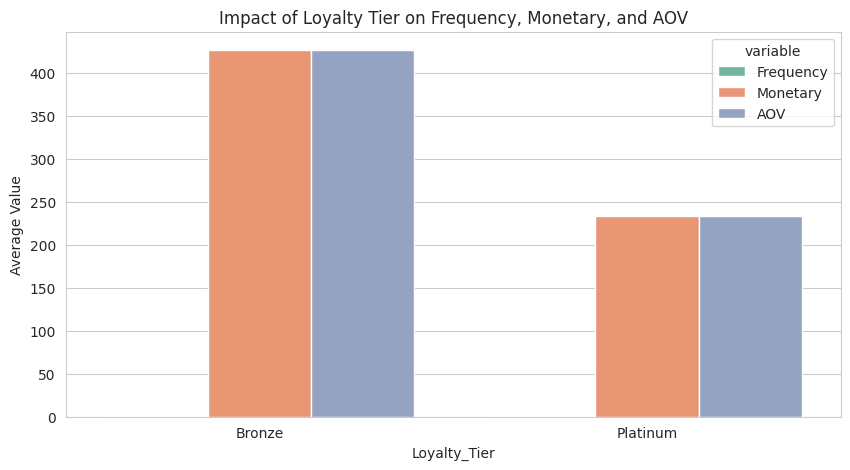

In [29]:
# Visualize Tier Impact on AOV and Frequency

plt.figure(figsize=(10,5))
sns.barplot(data=loyalty_summary.melt(id_vars='Loyalty_Tier', value_vars=['Frequency','Monetary','AOV']),
            x='Loyalty_Tier', y='value', hue='variable', palette='Set2')
plt.title('Impact of Loyalty Tier on Frequency, Monetary, and AOV')
plt.ylabel('Average Value')
plt.show()


In [ ]:
# Section B

# . Conversion Funnel Analysis

In [31]:
# Conversion Bottlenecks




# Merge web_session and user_clicks
funnel_df = web_session.merge(user_clicks, on=['Session_ID', 'Customer_ID'], how='left')

# Merge with cart_activity
funnel_df = funnel_df.merge(cart_activity, on=['Customer_ID'], how='left')

# Merge with orders to check for purchases
funnel_df = funnel_df.merge(orders[['Customer_ID', 'Order_ID']], on='Customer_ID', how='left')


# Re-checking available columns after merging
print(funnel_df.columns)

# Based on the merged dataframe, let's define the funnel stages
# Assuming 'Session_ID' is the Session_ID from web_session after merging, as it was the original column name and no suffix was added
funnel_df['Browsed'] = ~funnel_df['Session_ID'].isna()
funnel_df['Viewed_Product'] = ~funnel_df['Interaction_ID'].isna()
funnel_df['Added_To_Cart'] = ~funnel_df['Cart_ID'].isna()
funnel_df['Purchased'] = ~funnel_df['Order_ID'].isna()


# Funnel summary
funnel_summary = pd.DataFrame({
    'Stage': ['Browsed','Viewed_Product','Added_To_Cart','Purchased'],
    'Unique_Customers': [
        funnel_df[funnel_df['Browsed']]['Customer_ID'].nunique(),
        funnel_df[funnel_df['Viewed_Product']]['Customer_ID'].nunique(),
        funnel_df[funnel_df['Added_To_Cart']]['Customer_ID'].nunique(),
        funnel_df[funnel_df['Purchased']]['Customer_ID'].nunique()
    ]
})
funnel_summary['Conversion_%'] = funnel_summary['Unique_Customers']/funnel_summary['Unique_Customers'].iloc[0]*100
funnel_summary['Drop_Off_%'] = funnel_summary['Conversion_%'].diff().fillna(0).abs()

# Biggest drop-off
bottleneck_stage = funnel_summary.loc[funnel_summary['Drop_Off_%'].idxmax(),'Stage']
drop_value = funnel_summary['Drop_Off_%'].max()

print(f" Biggest drop-off occurs after '{bottleneck_stage}' stage ({drop_value:.2f}% loss).")
funnel_summary



Index(['Session_ID', 'Customer_ID', 'Session_Timestamp', 'Device_Type',
       'Browser', 'OS', 'Landing_Page', 'Exit_Page', 'Referral_Source',
       'Time_Spent_Seconds',
       ...
       'Product_Category_Mix_Score__Electronics_92',
       'Coupon_Eligibility_Check_Count__Apparel_93',
       'Items_Shipped_Free_Flag__FlashSale_94',
       'Product_Category_Mix_Score__WebSession_95',
       'Items_Shipped_Free_Flag__HeavyItem_96',
       'Coupon_Eligibility_Check_Count__WebSession_97',
       'Geolocation_Matches_Shipping_Flag__Apparel_98',
       'Coupon_Eligibility_Check_Count__FlashSale_99',
       'Time_Since_Last_Event__FlashSale_100', 'Order_ID'],
      dtype='object', length=343)
 Biggest drop-off occurs after 'Viewed_Product' stage (100.00% loss).


,Stage,Unique_Customers,Conversion_%,Drop_Off_%
0,Browsed,9,100.0,0.0
1,Viewed_Product,0,0.0,100.0
2,Added_To_Cart,0,0.0,0.0
3,Purchased,0,0.0,0.0


In [32]:
# Check if high recency customers

# Merge web_session and user_clicks
funnel_df = web_session.merge(user_clicks, on=['Session_ID', 'Customer_ID'], how='left')

# Merge with cart_activity
funnel_df = funnel_df.merge(cart_activity, on=['Customer_ID'], how='left')

# Merge with orders to check for purchases
funnel_df = funnel_df.merge(orders[['Customer_ID', 'Order_ID']], on='Customer_ID', how='left')

# Based on the merged dataframe, let's define the funnel stages
# Assuming 'Session_ID' is the Session_ID from web_session after merging, as it was the original column name and no suffix was added
funnel_df['Browsed'] = ~funnel_df['Session_ID'].isna() # Use 'Session_ID' from the merged dataframe
funnel_df['Viewed_Product'] = ~funnel_df['Interaction_ID'].isna() # Assuming Interaction_ID from user_clicks indicates viewing a product
funnel_df['Added_To_Cart'] = ~funnel_df['Cart_ID'].isna() # Assuming Cart_ID from cart_activity indicates adding to cart
funnel_df['Purchased'] = ~funnel_df['Order_ID'].isna() # Assuming Order_ID from orders indicates a purchase

funnel_analysis = funnel_df[['Customer_ID','Browsed','Viewed_Product','Added_To_Cart','Purchased']].merge(
    customer_agg[['Customer_ID','Recency']], on='Customer_ID', how='left'
)
funnel_analysis['High_Recency'] = np.where(funnel_analysis['Recency'] > 90, 1, 0)

high_recency_summary = funnel_analysis.groupby('High_Recency')[['Browsed','Viewed_Product','Added_To_Cart','Purchased']].mean()*100
high_recency_summary

,Browsed,Viewed_Product,Added_To_Cart,Purchased
High_Recency,,,,
0,100.0,0.0,0.0,0.0


In [1]:
# 7 7. Cannibalization / Complementarity Analysis

In [ ]:
plt.show()

In [3]:
# 8. Price Elasticity for Top 5 Categories

In [4]:
# Step 1: Identify top 5 categories by sales
category_sales = df_full.groupby('Category')['Total_Amount_USD'].sum().sort_values(ascending=False).head(5).index.tolist()

# Step 2: Compute price elasticity
elasticity = {}
for cat in category_sales:
    cat_data = df_full[df_full['Category']==cat]

    # Average price per product
    price_qty = cat_data.groupby('Product_ID')[['Price_USD','Order_ID']].agg({'Price_USD':'mean','Order_ID':'count'}).reset_index()

    # Percent change in quantity vs percent change in price
    price_qty['pct_qty'] = price_qty['Order_ID'].pct_change()
    price_qty['pct_price'] = price_qty["************************* w'Price_USD']".pct_change()
    price_qty = price_qty.dropna()

    # Elasticity = %ΔQ / %ΔP
    price_qty['elasticity'] = price_qty['pct_qty'] / price_qty['pct_price']
    elasticity[cat] = price_qty['elasticity'].mean()




SyntaxError: '[' was never closed (ipython-input-1174067681.py, line 14)

In [ ]:
# Display estimated price elasticity
pd.DataFrame(list(elasticity.items()), columns=['Category','Estimated_Price_Elasticity'])

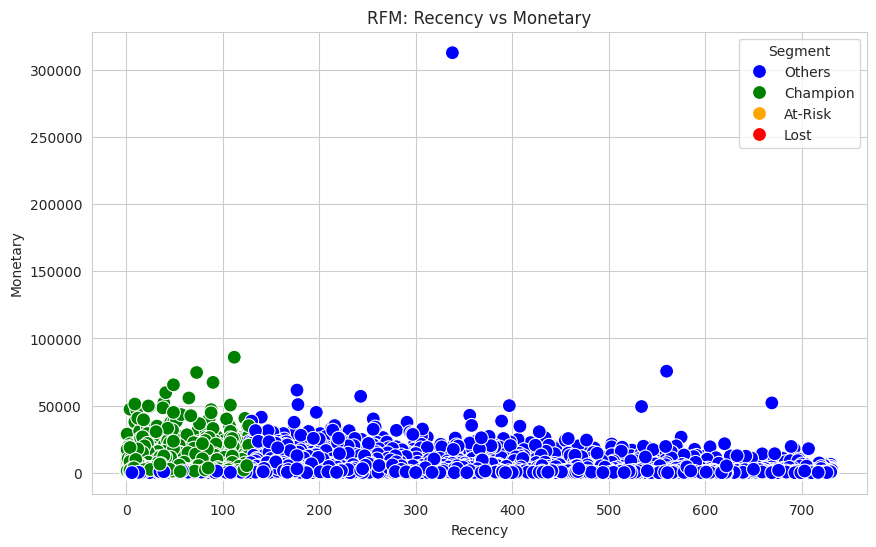

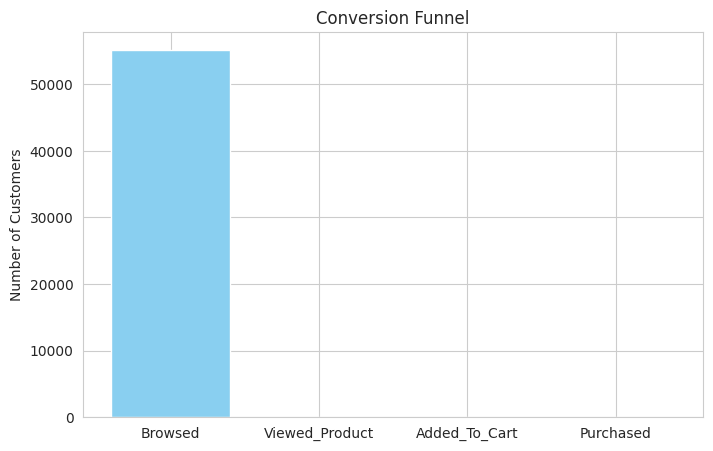

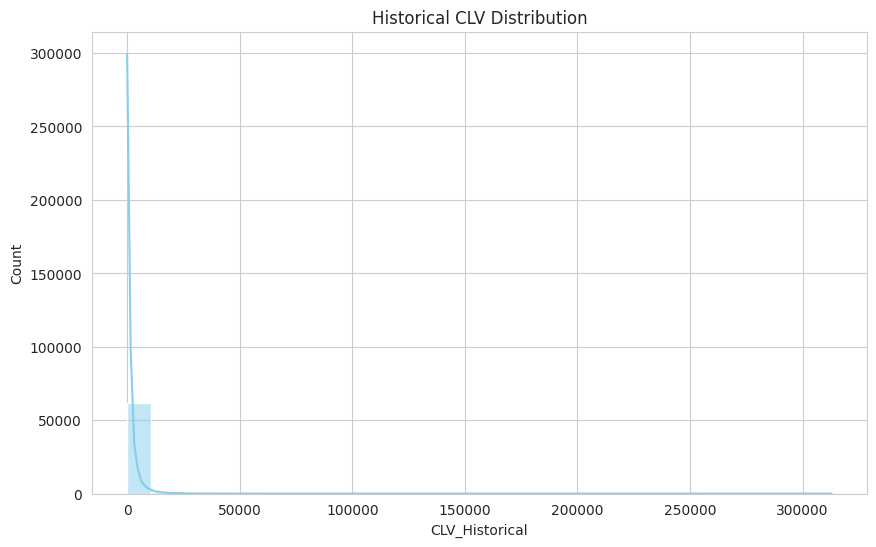

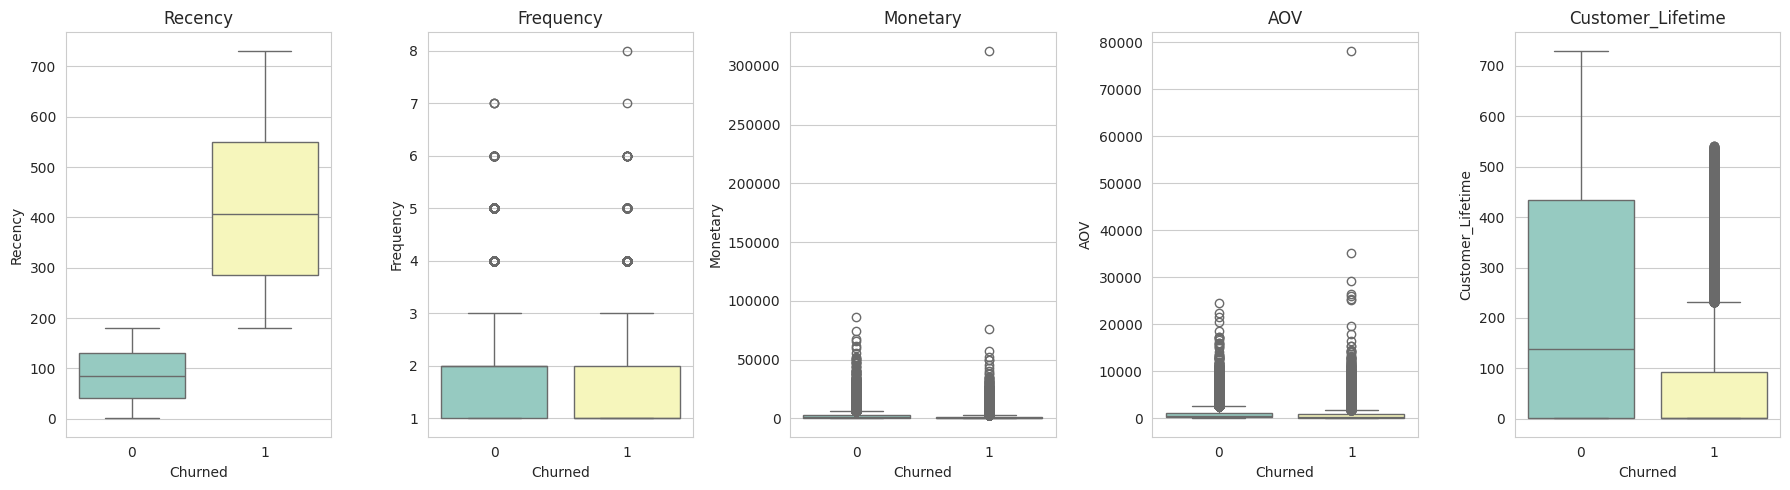

In [ ]:
# 1 visulazation
# RFM scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm_full, x='Recency', y='Monetary', hue='Segment',
                palette={'Champion':'green','At-Risk':'orange','Lost':'red','Others':'blue'}, s=100)
plt.title('RFM: Recency vs Monetary')
plt.show()

# Funnel bar chart
plt.figure(figsize=(8,5))
plt.bar(funnel_summary['Stage'], funnel_summary['Unique_Customers'], color=['#89CFF0','#00BFFF','#4682B4','#1E3A8A'])
plt.title('Conversion Funnel')
plt.ylabel('Number of Customers')
plt.show()

# CLV distribution
plt.figure(figsize=(10,6))
sns.histplot(clv_df['CLV_Historical'], bins=30, kde=True, color='skyblue')
plt.title('Historical CLV Distribution')
plt.show()

# Churn vs metrics
metrics = ['Recency','Frequency','Monetary','AOV','Customer_Lifetime']
plt.figure(figsize=(18,5))
for i, metric in enumerate(metrics,1):
    plt.subplot(1,len(metrics),i)
    sns.boxplot(x='Churned', y=metric, data=customer_agg, palette='Set3')
    plt.title(metric)
plt.tight_layout()
plt.show()


In [ ]:
customers = data['customers']
orders = data['orders']
marketing = data['marketing']